In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import json
import networkx as nx
from sklearn import preprocessing
from matplotlib.cm import ScalarMappable
from matplotlib.pyplot import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
sns.set()

# Read Data

In [4]:
path = "C:/Users/18565/Desktop/Classes/VA/Project/Code/VA-Project/"

In [5]:
df = pd.read_csv(os.path.join(path,"data\Lekagul Sensor Data.csv"))
new_df = df
new_df['gate_category'] = [i[:-1] for i in list(new_df['gate-name'])]
new_df.to_csv(os.path.join(path,"data\data with added gate category for tableau.csv"))
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index("Timestamp",inplace=True)

# Create dummies

In [6]:
dummy = pd.get_dummies(df['gate-name'],dtype=int)
numerical_data = pd.concat((df,dummy),axis=1)
summary = numerical_data.describe()

# Plot Std Mean of total traffic flux at each gate

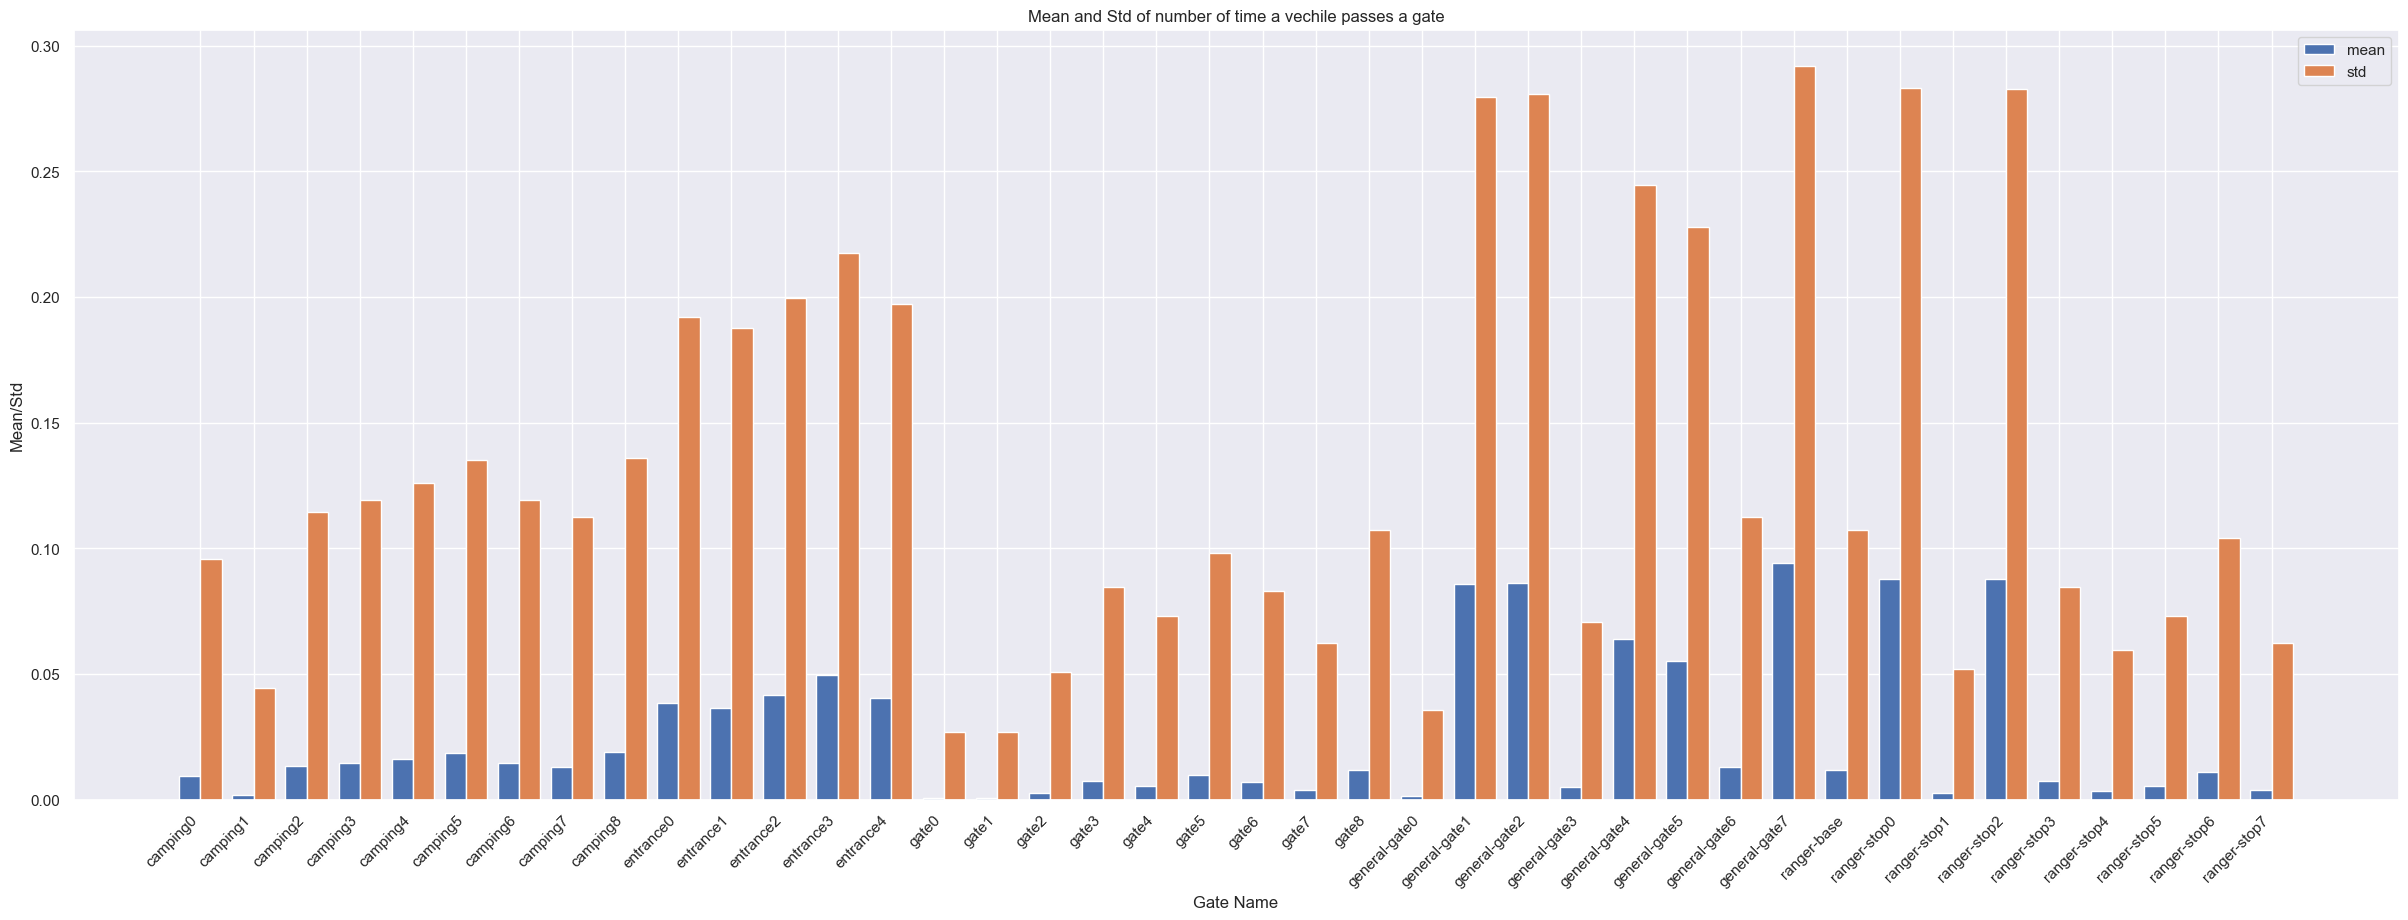

In [7]:
X = summary.columns
mean = list(summary.loc['mean'])
std = list(summary.loc['std'])
  
X_axis = np.arange(len(X)) 
fig = plt.figure(figsize=(30,10))
plt.bar(X_axis - 0.2, mean, 0.4, label = 'mean') 
plt.bar(X_axis + 0.2, std, 0.4, label = 'std') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Gate Name") 
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean/Std") 
plt.title("Mean and Std of number of time a vechile passes a gate") 
plt.legend() 
plt.show() 

# Traffic flux of different cars types aggregated over time period day and week.

In [8]:
df['count'] = np.ones(len(df))

In [9]:
colors = cm.rainbow(np.linspace(0, 1, 3))

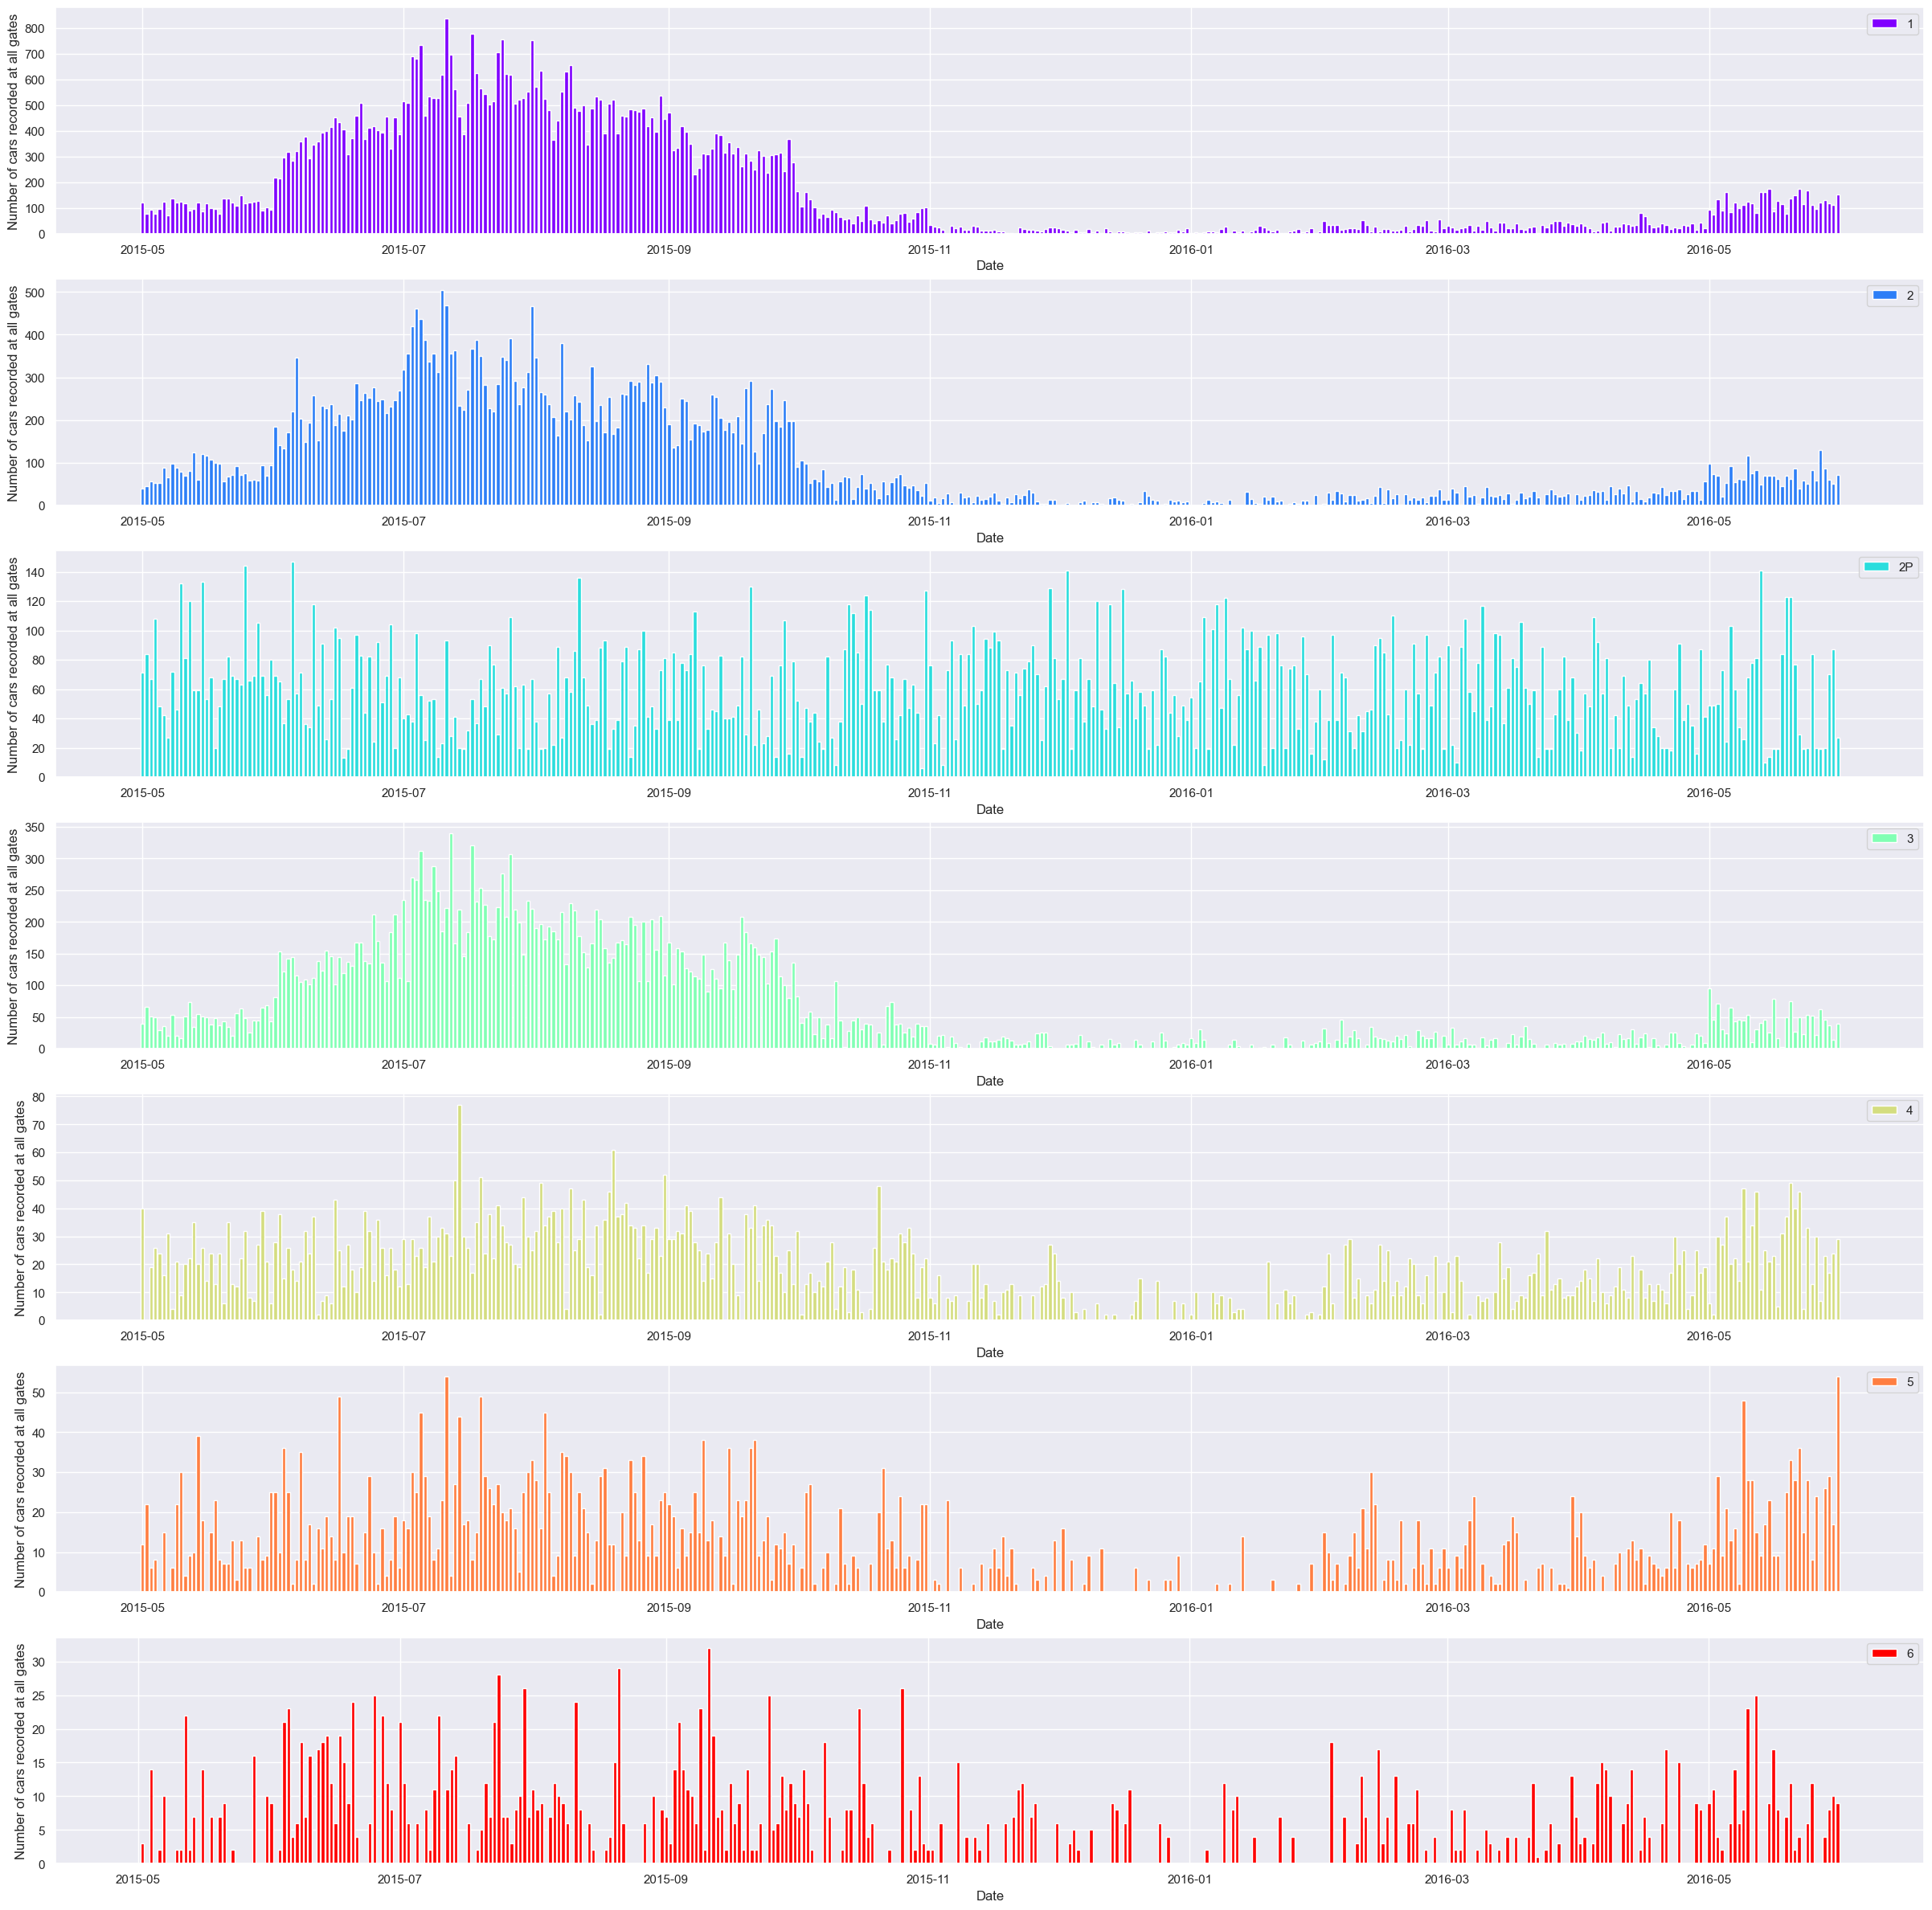

In [10]:
fig,ax = plt.subplots(7,1,figsize=(30,30))
cartypes = np.unique(df['car-type'])
colors = cm.rainbow(np.linspace(0, 1, len(cartypes)))
count = 0
ind = np.arange(len(cartypes))
width = 0.1
for cartype in cartypes:
    by_date = df[df['car-type']==cartype].groupby([df[df['car-type']==cartype].index.date])[['count']].sum()
    ax[count].bar(by_date.index, by_date['count'],label=cartype,color=colors[count])
    ax[count].legend()
    ax[count].set_xlabel("Date")
    ax[count].set_ylabel("Number of cars recorded at all gates")
    count+=1 
plt.show() 
    

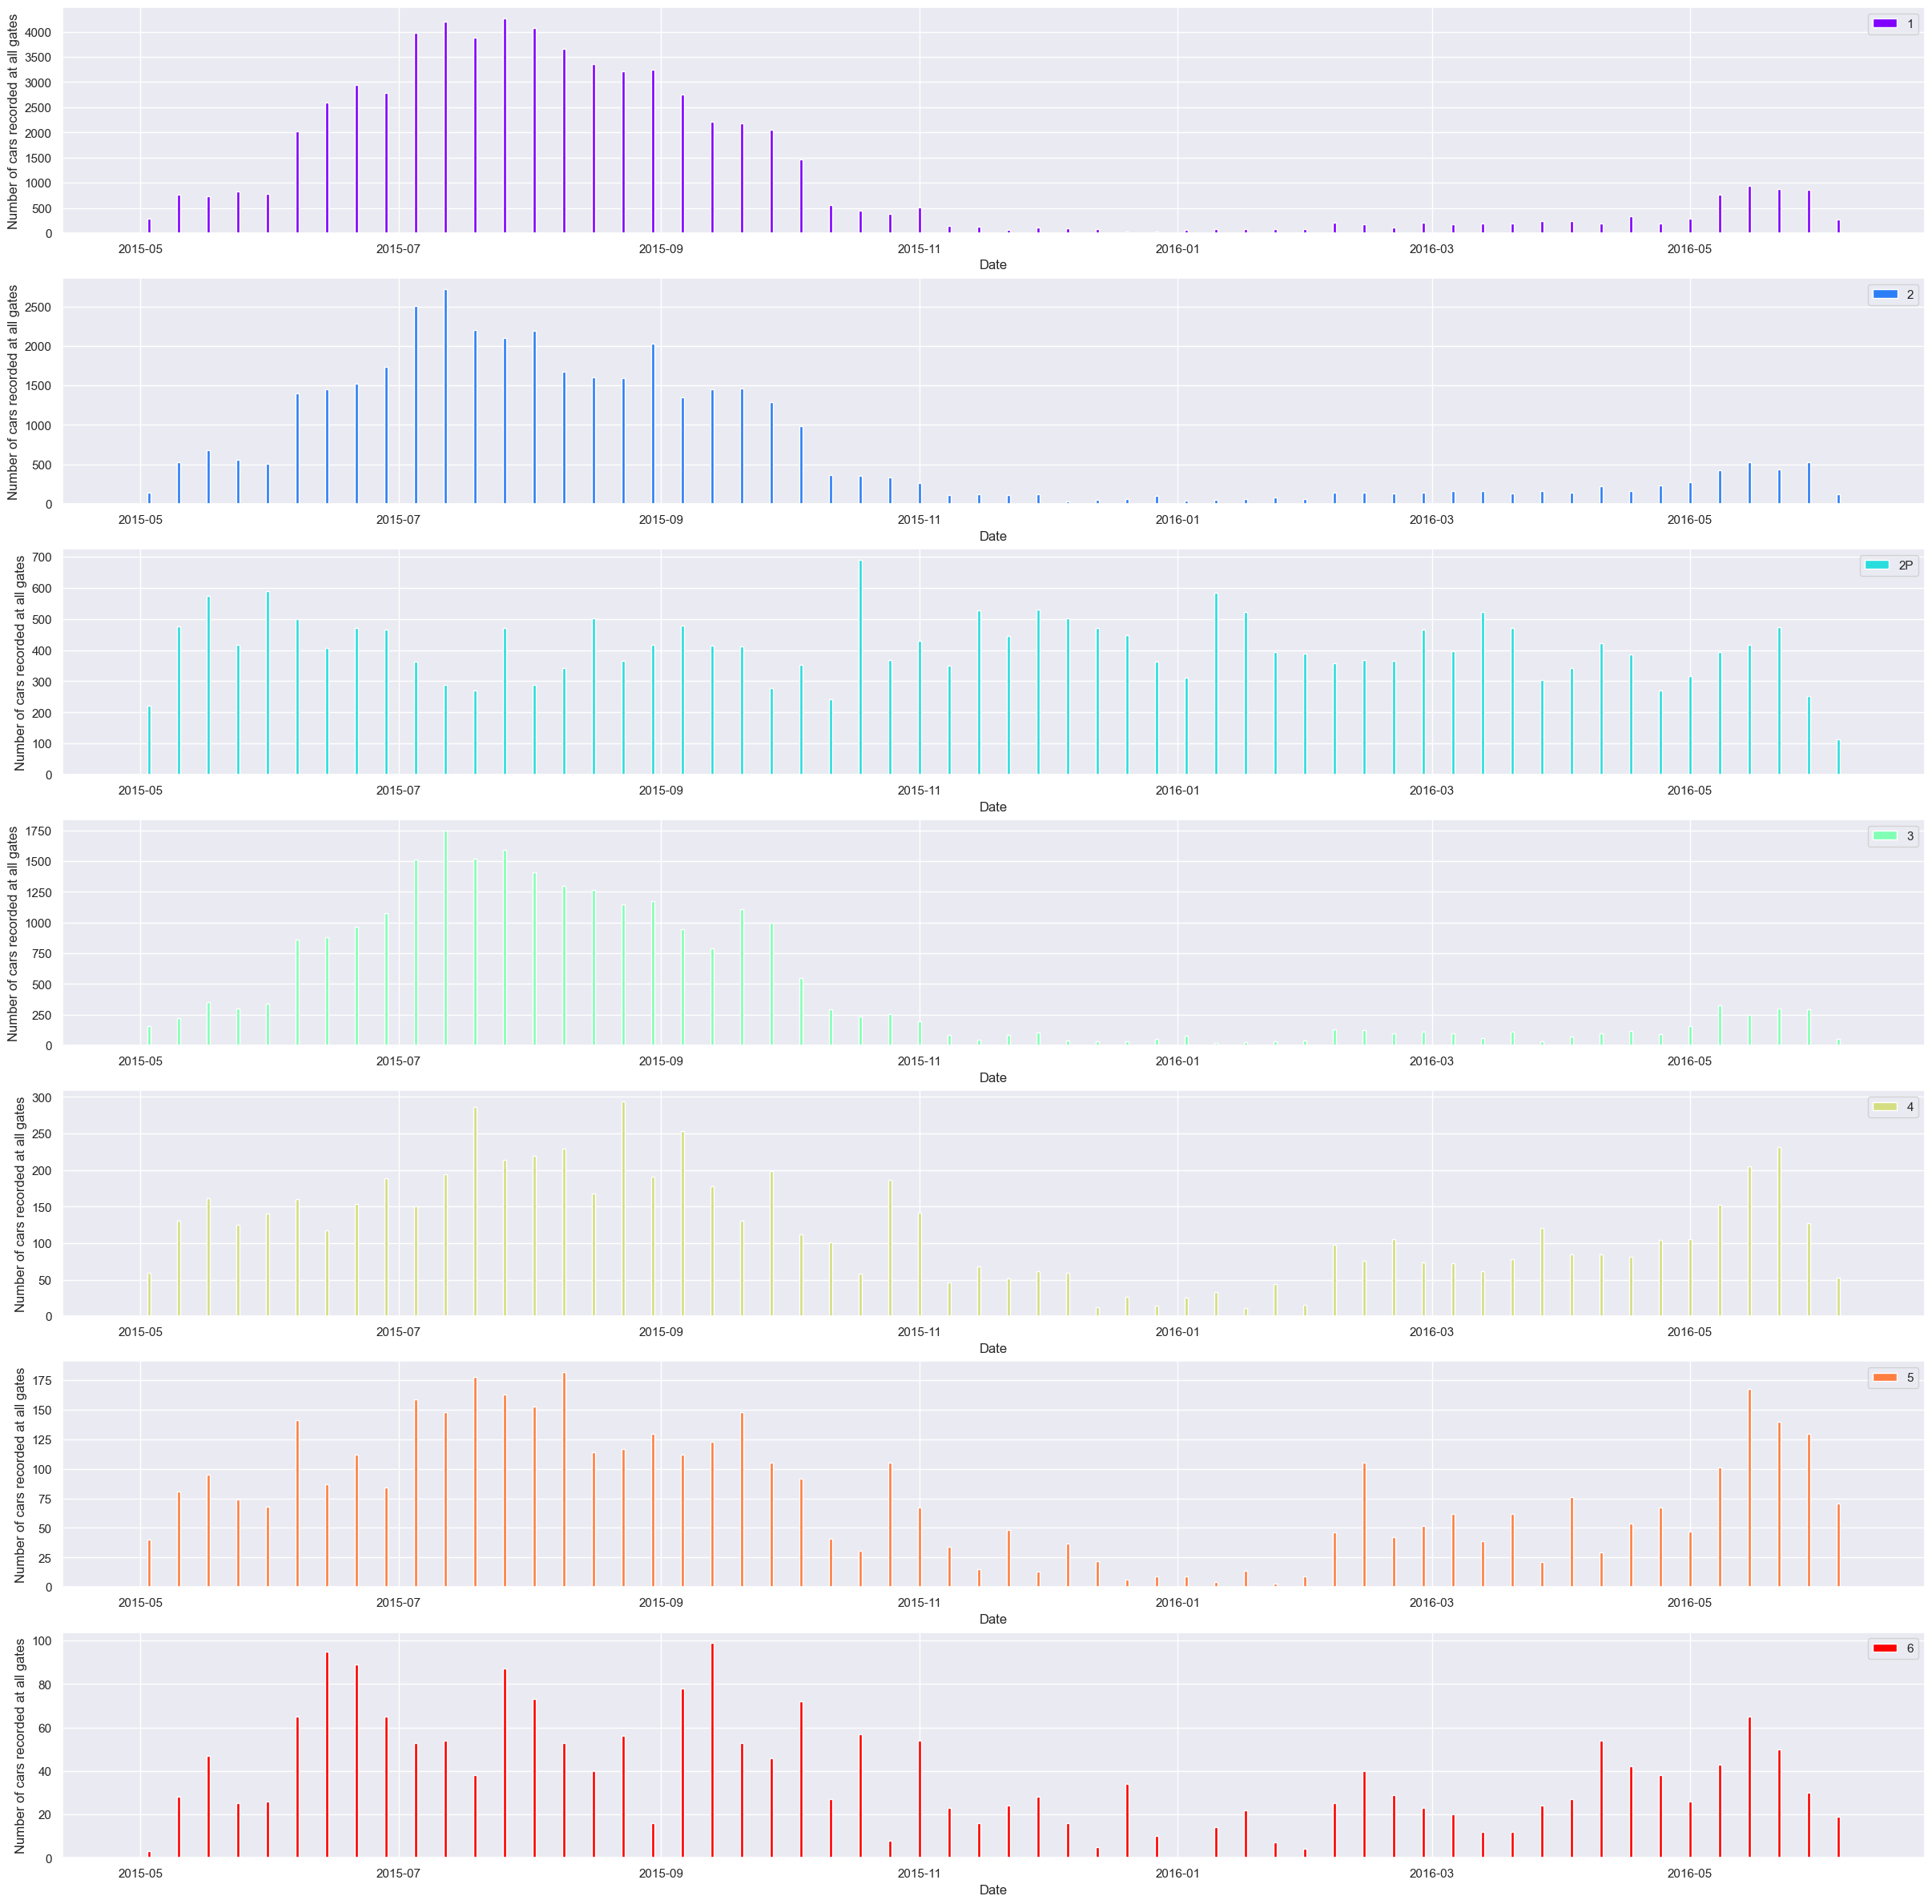

In [11]:
fig,ax = plt.subplots(7,1,figsize=(30,30))
cartypes = np.unique(df['car-type'])
colors = cm.rainbow(np.linspace(0, 1, len(cartypes)))
count = 0
ind = np.arange(len(cartypes))
width = 0.1
for cartype in cartypes:
    by_week = df[df['car-type']==cartype].groupby(pd.Grouper(freq='W'))[['count']].sum()
    ax[count].bar(by_week.index, by_week['count'],label=cartype,color=colors[count])
    ax[count].legend()
    ax[count].set_xlabel("Date")
    ax[count].set_ylabel("Number of cars recorded at all gates")
    count+=1 
plt.show() 

# Traffic flux at each gate aggregated over time period day and week

In [12]:
by_date_numerical_data = numerical_data.groupby(numerical_data.index.date)[numerical_data.columns[5:]].sum()

In [13]:
by_date_numerical_data.head(2)

,camping1,camping2,camping3,camping4,camping5,camping6,camping7,camping8,entrance0,entrance1,...,general-gate7,ranger-base,ranger-stop0,ranger-stop1,ranger-stop2,ranger-stop3,ranger-stop4,ranger-stop5,ranger-stop6,ranger-stop7
2015-05-01,0,4,8,0,2,4,2,4,6,10,...,26,8,30,0,28,2,2,4,6,0
2015-05-02,0,3,5,2,3,3,1,3,11,11,...,27,6,23,2,23,4,2,2,8,6


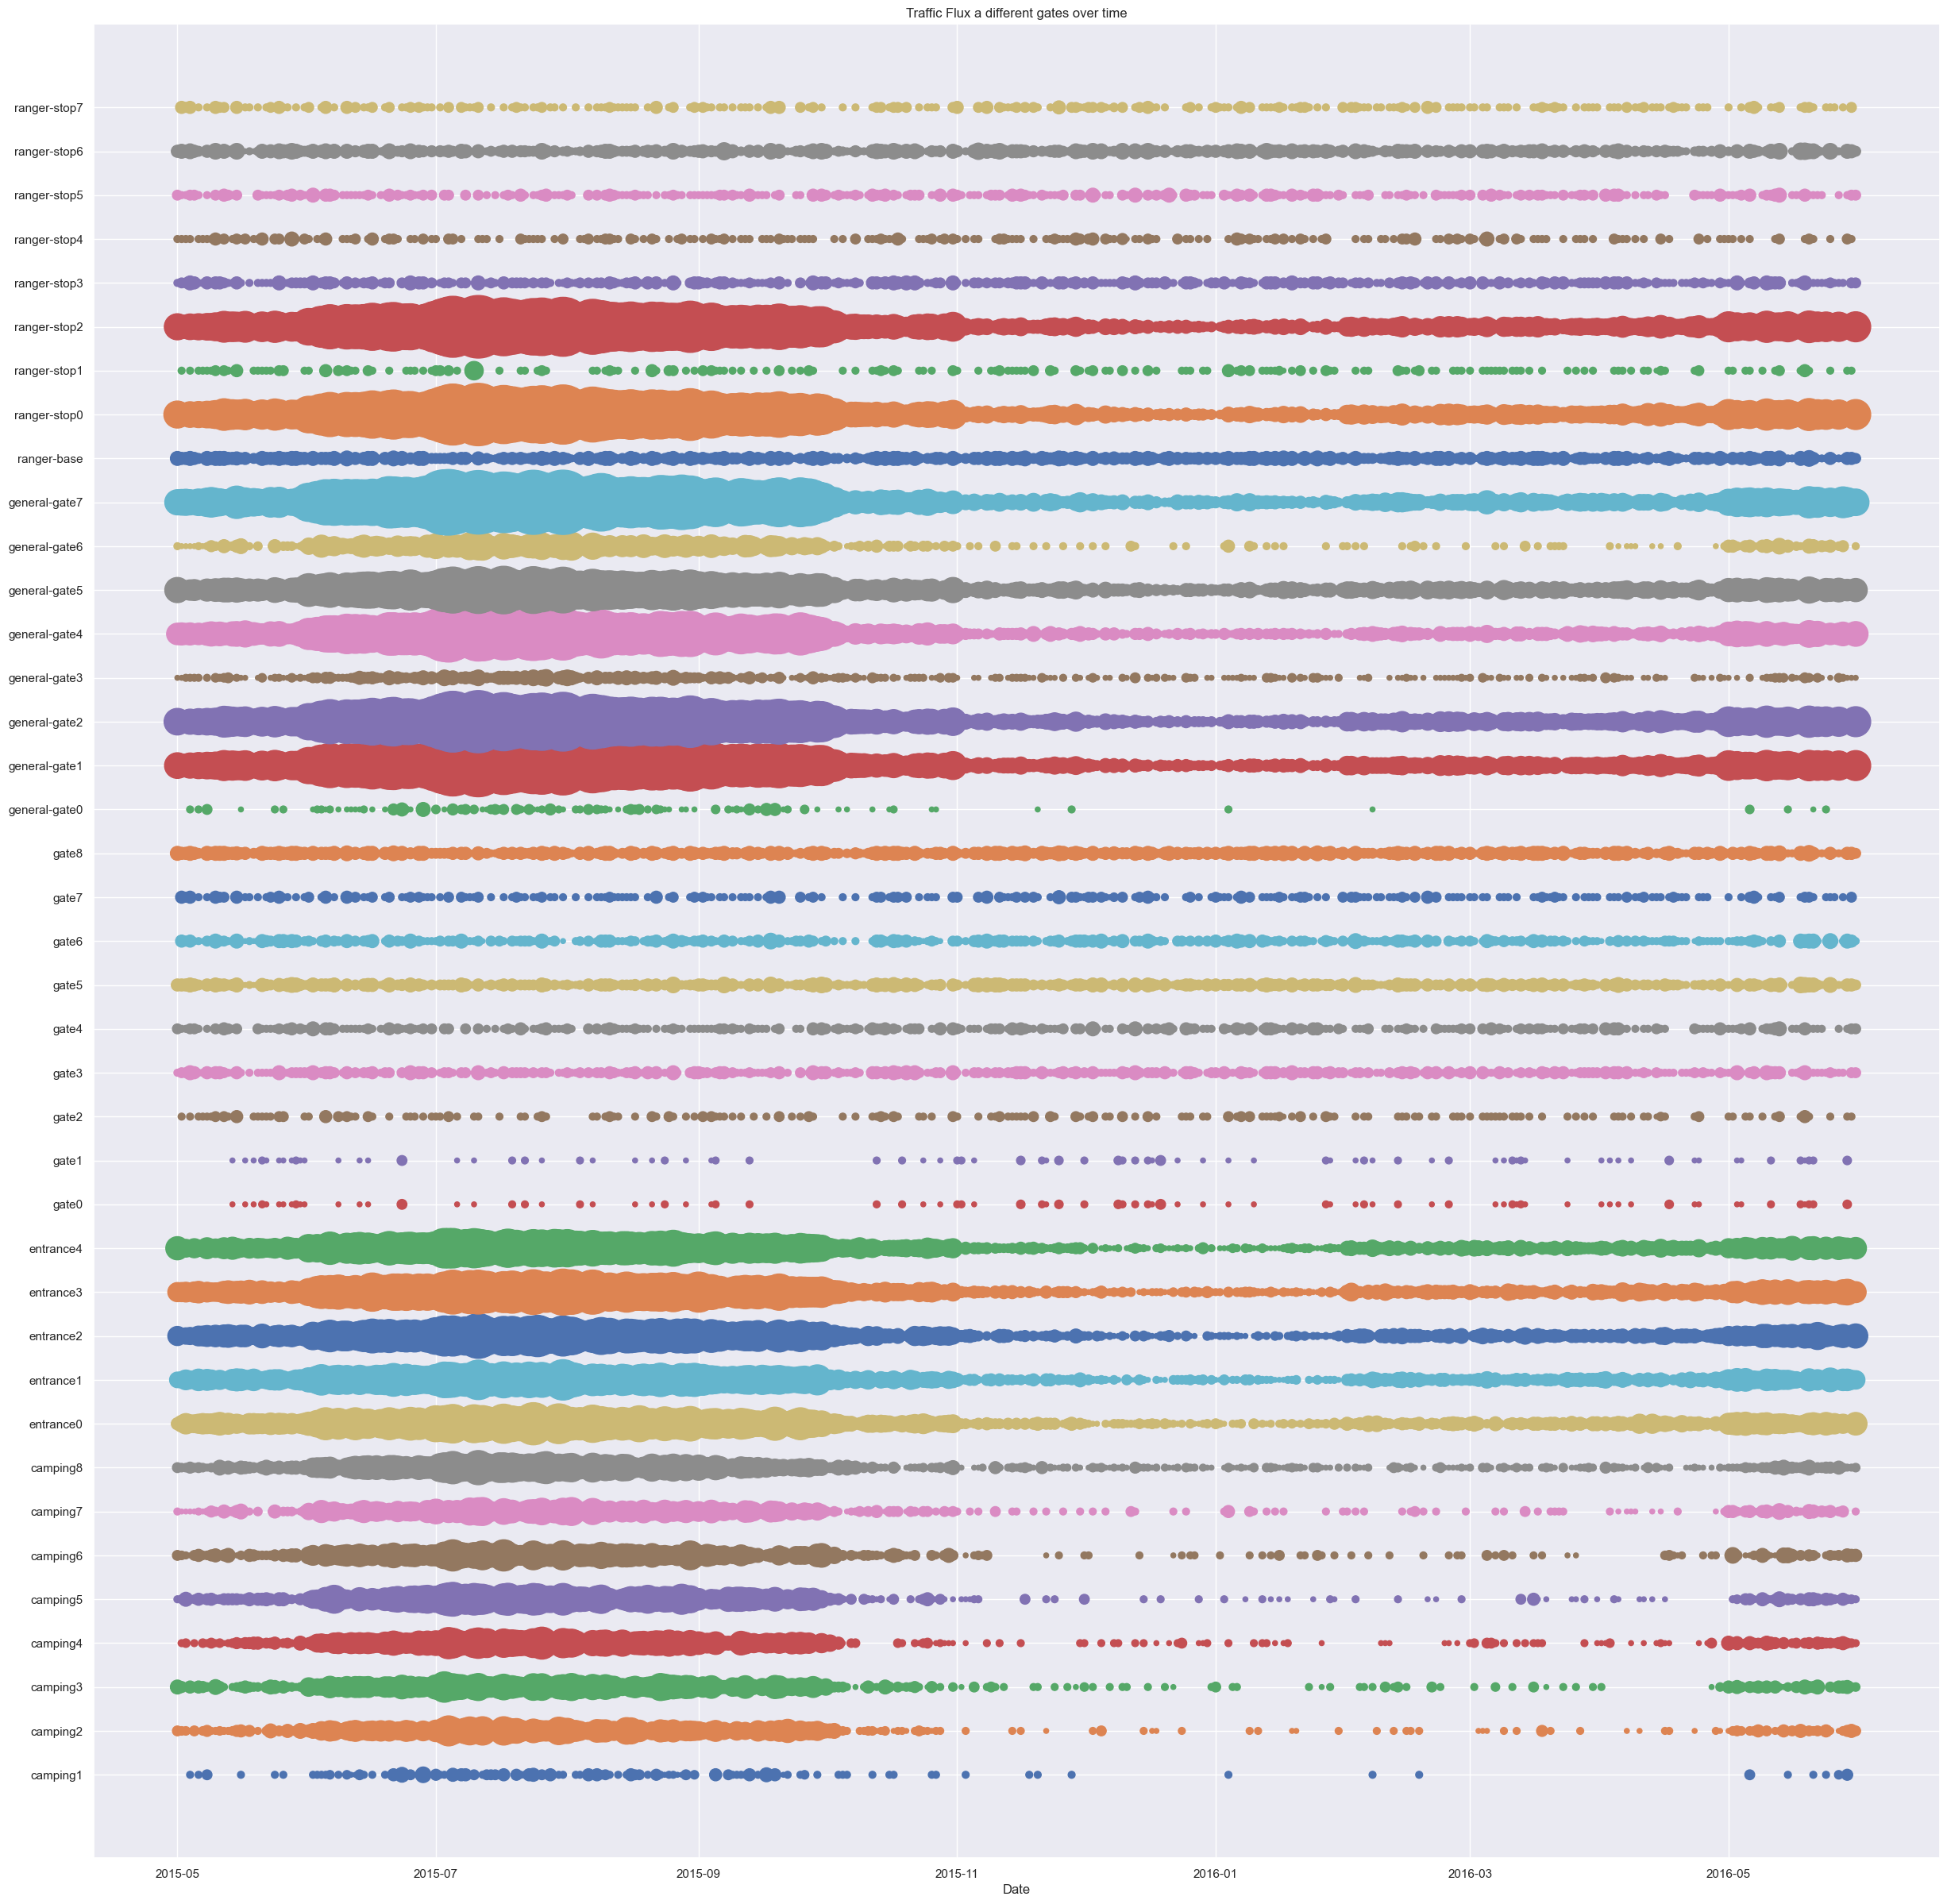

In [14]:
fig, ax = plt.subplots(figsize=(30,30))
for col in by_date_numerical_data.columns:
    ax.scatter(by_date_numerical_data.index, [col] * len(by_date_numerical_data), s=by_date_numerical_data[col]*20, label=col)
ax.set_xlabel('Date')
ax.set_title('Traffic Flux a different gates over time')
plt.show()

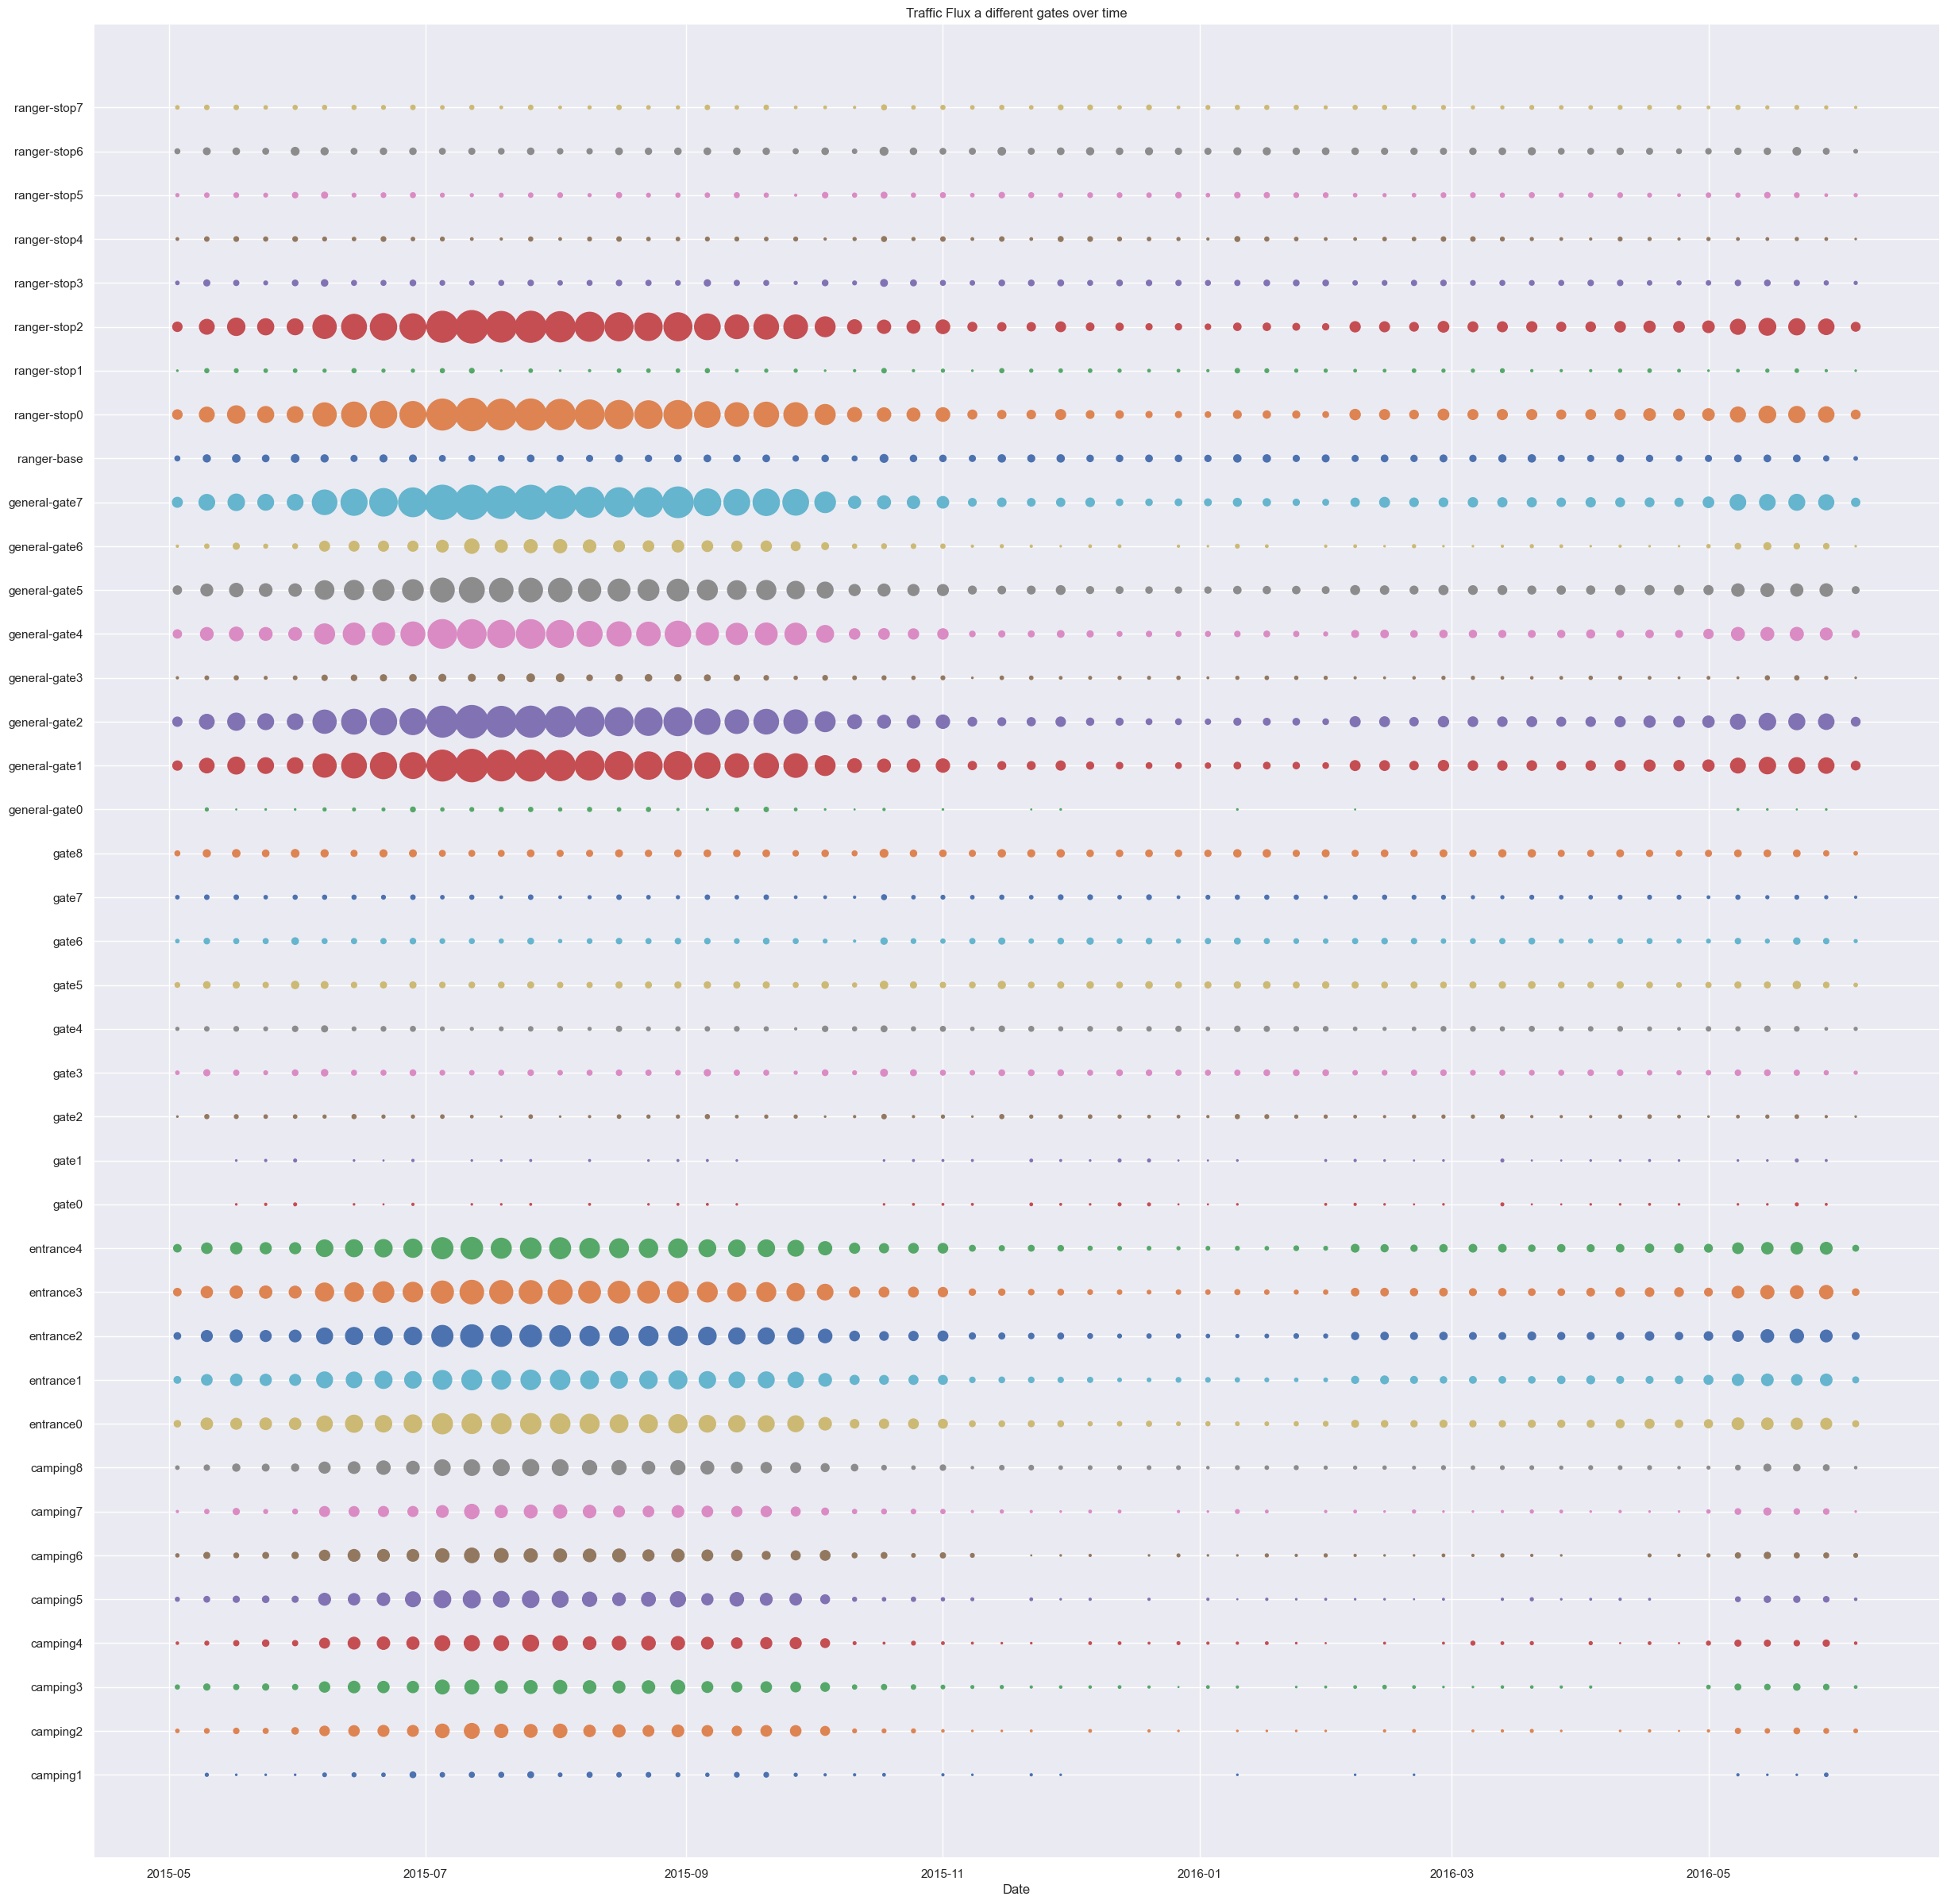

In [15]:
by_week_numerical_data = numerical_data.groupby(pd.Grouper(freq='w'))[numerical_data.columns[5:]].sum()
fig, ax = plt.subplots(figsize=(30,30))
for col in by_week_numerical_data.columns:
    ax.scatter(by_week_numerical_data.index, [col] * len(by_week_numerical_data), s=by_week_numerical_data[col], label=col)
ax.set_xlabel('Date')
ax.set_title('Traffic Flux a different gates over time')
plt.show()

Need to fix bubble size
```
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

fig = make_subplots(rows=len(by_date_numerical_data.columns), cols=1,vertical_spacing=0)

i = 0
for  col in by_date_numerical_data.columns:
    fig.add_trace(px.scatter(x=by_date_numerical_data.index,y=[col]*len(by_date_numerical_data),size=by_date_numerical_data[col].values).data[0],row=i+1,col=1)
    i+=1

fig.update_layout(height=len(by_date_numerical_data.columns)*50)
fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_xaxes(showticklabels=True, row=40, col=1)
fig.update_layout(title=dict(text="Traffic flux at different gates over time", font=dict(size=20), automargin=True, yref='paper'))
fig.show()
```

# Change Data structure to JSON

In [16]:
def create_json(df):
    r"""retruns dictionary with keys data, edges and nodes 
        args:
        df (pd.DataFrame) : Lekagul Sensor Data 
    """
    pbar = tqdm(total=len(df))
    pbar.set_description("Data Processing :")

    car_ids = np.unique(df['car-id'])
    data_dic = {"data":[],"edges":None}
    data_dic["nodes"] = list(np.unique(df['gate-name']))
    all_edge_names = []
    for car_id in car_ids:
        row_data = {'car-id':car_id,'path_taken':[]}
        car_data = df[df['car-id']==car_id]
        row_data["car_type"] = np.unique(car_data['car-type'])[0]
        row_data['enter_date'] = str(car_data.index[0])
        row_data['exit_date'] = str(car_data.index[-1])
        total_time = car_data.index[-1]-car_data.index[0]
        total_time = total_time.total_seconds()/60
        row_data['total_in_time'] = round(total_time,2)
        for ind in range(1,len(car_data)):
            dic_key =car_data['gate-name'].iloc[ind-1]+ " to " +car_data['gate-name'].iloc[ind]
            delta = car_data.index[ind]-car_data.index[ind-1]
            delta = delta.total_seconds()/60
            
            row_data['path_taken'].append({dic_key:round(delta,2)})
            if dic_key not in all_edge_names:
                all_edge_names.append(dic_key)
        data_dic["data"].append(row_data)
        pbar.update(len(car_data))
    data_dic['edges'] =  all_edge_names
    pbar.close()
    return data_dic

In [17]:
def seperate_cartype_data(data):
    r"""returns data separated by cartype
        Args:
            Data (dictionary) : dic returned by create_json function"""
    new_dic = {'1':[], '2':[], '2P':[], '3':[], '4':[], '5':[], '6':[]}
    for one_car in data['data']:
        new_dic[one_car['car_type']].append(one_car)
        data['data'] = new_dic
    return data

In [ ]:
data_json = create_json(df)

In [ ]:
data = seperate_cartype_data(data_json)

In [ ]:
with open(os.path.join("/data/json_data.json", "w")) as outfile: 
    json.dump(data, outfile)

# yet to fix

In [ ]:
file_ = open("C:/Users/18565/Desktop/Classes/VA/Project/Code/VA-Project/Python/Notebooks/data.json")

In [ ]:
data_json = json.loads(file_.read())

In [ ]:
len(data_json['edges']),len(data_json['nodes'])

In [ ]:
 def get_node_visited_data(df):
    pbar = tqdm(total=len(df))
    pbar.set_description("Data Processing :")
    car_ids = np.unique(df['car-id'])
    columns = [["entry_time","exit_time","total_time","car_type","car_id"] + data_json['nodes']]
    for car_id in car_ids:
        row_data = [0]*len(columns[0])
        car_data = df[df['car-id']==car_id]
        row_data[4] = car_id
        row_data[3] = np.unique(car_data['car-type'])[0]
        row_data[0] = str(car_data.index[0])
        row_data[1] = str(car_data.index[-1])
        total_time = car_data.index[-1]-car_data.index[0]
        total_time = total_time.total_seconds()/60
        row_data[2] = round(total_time,2)
        for ind in range(len(car_data)):
            key =car_data['gate-name'].iloc[ind-1]
            row_data[columns[0].index(key)] = 1
        columns.append(row_data)   
        pbar.update(len(car_data))
    pbar.close()
    return columns
    

In [ ]:
node_visited_data = get_node_visited_data(df)

In [ ]:
node_data = pd.DataFrame(data=node_visited_data[1:],columns=node_visited_data[0])

In [ ]:
node_data['entry_time'] = pd.to_datetime(node_data['entry_time'])
node_data['exit_time'] = pd.to_datetime(node_data['exit_time'])

In [ ]:
node_data.set_index('entry_time',inplace=True)

In [ ]:
node_data.sort_index(inplace=True)

In [ ]:
with open("data.json", "w") as outfile: 
    json.dump(data, outfile)

In [ ]:
def get_edges(data):
    r"""returns normal and selfloop edges of a specific cartype
        args:
            data (dictionary) : dictionary data of a specific cartype"""
    edges = {"normal":{},"selfloop":{}}
    for car in data:
        for path in car['path_taken']:
            for key in path.keys():
                if (key.split(" ")[0]!=key.split(" ")[2]):
                    if key in edges['normal'].keys():
                        edges['normal'][key] += path[key]
                    else:
                        edges['normal'][key] = path[key]
                else:
                    if key in edges['selfloop'].keys():
                        edges['selfloop'][key] += path[key]
                    else:
                        edges['selfloop'][key] = path[key]
                    
    return edges

In [ ]:
all_edges = get_edges(data_json['data']['1']) 

In [ ]:
n_edge_weights = preprocessing.normalize(np.array(list(all_edges['normal'].values())).reshape(1,len(list(all_edges['normal'].values()))))
sl_edge_weights = preprocessing.normalize(np.array(list(all_edges['selfloop'].values())).reshape(1,len(list(all_edges['selfloop'].values()))))

In [ ]:
n_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in all_edges['normal'].keys()]
sl_edge_names = [(key.split(" ")[0],key.split(" ")[2]) for key in all_edges['selfloop'].keys()]

In [ ]:
graph = nx.DiGraph()

In [ ]:
graph.add_edges_from(n_edge_names)
graph.add_edges_from(sl_edge_names)

In [ ]:
self_nodes =[i[0] for i in sl_edge_names ]

In [ ]:
# create list of all nodes and a weight array that gives the time spend at that node
node_sizes = []
all_nodes = []
for j in graph.nodes():
    if j in self_nodes:
        node_sizes.append(sl_edge_weights[0][self_nodes.index(j)])
        all_nodes.append(j)
    else:
        node_sizes.append(0)
        all_nodes.append(j)

In [ ]:
node_weights = node_sizes + min(sl_edge_weights[0])

In [ ]:
node_weights = node_weights*30000

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(30,30), tight_layout=True,gridspec_kw={'width_ratios': [29, 1]}) 
pos = nx.spring_layout(graph,seed=63)
n_colors = n_edge_weights[0]
sl_colors = sl_edge_weights[0]

n_my_cmap = plt.cm.Oranges
sl_my_cmap = plt.cm.Blues

n_options = {
    "edge_color": n_colors,
    "width" : 6,
    "edge_cmap": n_my_cmap
}

sl_options = {
    "edge_color": sl_colors,
    "width" : 6,
    "edge_cmap": sl_my_cmap
}


nx.draw_networkx_nodes(graph, pos,nodelist=all_nodes, cmap=plt.get_cmap('jet'), node_size = node_weights,ax=ax[0])
nx.draw_networkx_labels(graph, pos,ax= ax[0])
nx.draw_networkx_edges(graph, pos, edgelist= n_edge_names, arrows=False,ax=ax[0],**n_options)
# nx.draw_networkx_edges(graph, pos, edgelist= sl_edge_names, arrows=False,ax=ax[0],**sl_options)


n_sm = ScalarMappable(cmap=n_my_cmap, norm=plt.Normalize(0,max(n_edge_weights[0])))
# sl_sm = ScalarMappable(cmap=sl_my_cmap, norm=plt.Normalize(0,max(sl_edge_weights[0])))

n_sm._A = []
# sl_sm._A = []
plt.colorbar(n_sm,ax[1])
# plt.colorbar(sl_sm,ax[2])

plt.show()

In [ ]:
not_2p_df = df[df['car-type']!='2P']

In [ ]:
illegal_pass = not_2p_df[not_2p_df['gate-name'].isin(['gate1','gate2','gate3','gate4','gate5','gate6','gate7','gate8'])]

In [ ]:
dummy_ = pd.get_dummies(illegal_pass['gate-name'],dtype=int)

In [ ]:
illegal_num_data = pd.concat((illegal_pass,dummy_))

In [ ]:
illegal_num_data.columns

In [ ]:
by_date_illegal_pass = illegal_num_data.groupby(illegal_num_data.index.date)[illegal_num_data.columns[3:]].sum()

In [ ]:
g3 = by_date_illegal_pass['gate3']!=0
g5 = by_date_illegal_pass['gate5']!=0
g6 = by_date_illegal_pass['gate6']!=0

In [ ]:
len(g3), len(g5),len(g6)

In [ ]:
ind_with_value = g3 | g5 | g6

In [ ]:
by_date_illegal_pass[ind_with_value]

In [ ]:
fig, ax = plt.subplots()
for col in by_date_illegal_pass.columns:
    ax.scatter(by_date_illegal_pass.index, [col] * len(by_date_illegal_pass), s=by_date_illegal_pass[col], label=col)
ax.set_xlabel('Date')
ax.set_title('Vechiles type 4 passing ranger gates')
plt.show()

In [ ]:
cars_with_illegal_pass = not_2p_df[not_2p_df['car-id'].isin(illegal_pass['car-id'])]
np.unique(cars_with_illegal_pass['car-id'])
for i in np.unique(cars_with_illegal_pass['car-id']):
    print("->".join(list(cars_with_illegal_pass[cars_with_illegal_pass['car-id']==i]['gate-name'])))

In [ ]:
nodes = []
edges = []
edge_weights = []
for i in np.unique(cars_with_illegal_pass['car-id']):
    temp = cars_with_illegal_pass[cars_with_illegal_pass['car-id']==i]
    nodes.append(list(temp['gate-name']))
    t_nodes =[]
    t_weights = []
    for j in range(len(temp)-1):
        t_nodes.append((temp['gate-name'].iloc[j],temp['gate-name'].iloc[j+1]))
        delta = temp.index[j+1]-temp.index[j]
        t_weights.append(delta.total_seconds()/60)
    edges.append(t_nodes)
    edge_weights.append(t_weights)
    

In [ ]:
delta.total_seconds()

In [ ]:
graphs = []
for node,edge in zip(nodes,edges):
    graph = nx.DiGraph()
    graph.add_nodes_from(node)
    graph.add_edges_from(edge)
    graphs.append(graph)    

In [ ]:
def plot_graph(graph,edges,edge_weights): 
    fig, ax = plt.subplots(1,2, figsize=(7,7), tight_layout=True,gridspec_kw={'width_ratios': [6, 1]}) 
    pos = nx.spring_layout(graph,seed=63)
    n_colors = edge_weights
    n_my_cmap = plt.cm.Oranges
    n_options = {
        "edge_color": n_colors,
        "width" : 6,
        "edge_cmap": n_my_cmap
    }
    nx.draw_networkx_nodes(graph, pos,ax=ax[0])
    nx.draw_networkx_labels(graph, pos,ax= ax[0])
    nx.draw_networkx_edges(graph, pos, edgelist= edges, arrows=False,ax=ax[0],**n_options)
    n_sm = ScalarMappable(cmap=n_my_cmap, norm=plt.Normalize(0,max(edge_weights)))
    n_sm._A = []
    plt.colorbar(n_sm,ax[1])
    plt.show()

In [ ]:
plot_graph(graphs[17],edges[17],edge_weights[17])